In [1]:
%matplotlib inline

from pathlib import Path
import sys
sys.path.append("../../")

import anamic

import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipyvolume as ipv

../../anamic/transformations.py:1916: UserWarning: No module named 'anamic._transformations'
  warnings.warn(str(err))


50


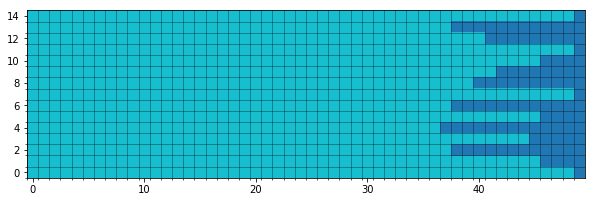

In [2]:
# Define the structure of the MT
# as a 2D array where:
# - x corresponds to rows of dimers.
# - y corresponds to each protofilaments.
# - a value of 1 means there is a dimer.
# - a value of 0 means there is nothing.

n_pf = 15
long_dimer_distance = 8  # nm
mt_length = 400  # nm
taper_length_nm = 150  # nm

n_rows = int(np.round(mt_length / long_dimer_distance))
print(n_rows)

dimers = np.ones((n_pf, n_rows))
dimers = anamic.structure.generate_uniform_taper(dimers, taper_length_nm)

_ = anamic.viz.viz_dimers(dimers, start_row=0, grid=True)

In [3]:
# Calculate the x, y and z positions of each dimers.
# Note that this code is packed in the following function:
# `anamic.structure.get_dimer_positions(dimers)`

n_pf = dimers.shape[0]
n_rows = dimers.shape[1]

# Get the parameters of geometry structure
# according to the number of pf.
params = anamic.structure.get_structure_parameters().loc[n_pf].to_dict()

long_dimer_distance = 8  # nm

# Calculate the radius of the MT from n_pf
mt_radius = ((16.4 * n_pf + 15) / 2) / 10

# The dimer_factor is needed because we calculate theta from
# dimer's center to dimer's center (not from monomer center).
dimer_factor = 2/3

# Calculate the theta angle (TODO: needs a better description)
theta = (360 - n_pf * params['hrot']) * dimer_factor

# Calculate the skew angle, the angle from one row to the next.
skew_angle = -1 * np.arcsin(0.25 * mt_radius * np.sin(0.5 * np.deg2rad(theta)))

# Init the list of positions
positions = pd.DataFrame()

# Calculate the position of the dimers
# of the first row.
i_row = 0
for i_pf in range(n_pf):
    datum = {}
    
    # Row index
    datum['row'] = i_row
    
    # Protofilament index
    datum['pf'] = i_pf

    # Spatial coordinates
    datum['x'] = mt_radius * np.sin(i_pf * np.deg2rad(params['hrot']))
    datum['y'] = mt_radius * np.cos(i_pf * np.deg2rad(params['hrot']))
    datum['z'] = i_pf * params['htrans']
    
    # Is the dimer visible ?
    datum['visible'] = dimers[i_pf, i_row] == 1
    
    # Store the positions in the dataframe
    positions = positions.append(pd.Series(datum), ignore_index=True)

# Starting from the first row, we calculcate
# the rows of dimers above it by applying:
# - a translation along the Z axis.
# - a rotation on the Z axis
i_helix = 0
first_row = positions[positions['row'] == 0]
for i_row in range(1, n_rows):
    
    current_row = first_row.copy()
    current_row['row'] = i_row

    # Apply translation.
    shift = i_row * long_dimer_distance * np.cos(skew_angle)
    current_row['z'] += shift
    
    # Apply rotation
    rotation = np.deg2rad(i_row * theta)
    Rz = anamic.transformations.rotation_matrix(rotation, [0, 0, 1])
    current_row[['x', 'y', 'z']] = np.dot(current_row[['x', 'y', 'z']].values, Rz[:3, :3].T)
    current_row['visible'] = dimers[:, i_row] == 1

    # Add new row's dimer positions to dataframe.
    positions = positions.append(current_row, ignore_index=True)

In [4]:
positions.head()

,pf,row,visible,x,y,z
0,0.0,0.0,1.0,0.000000,13.050000,0.000
1,1.0,0.0,1.0,5.272517,11.937465,1.081
2,2.0,0.0,1.0,9.646052,8.789550,2.162
3,3.0,0.0,1.0,12.374901,4.142986,3.243
4,4.0,0.0,1.0,12.993786,-1.209972,4.324


In [5]:
# Visualize the dimers position in 3D
anamic.viz.viz_dimer_positions(positions, size=2, color_feature_name='pf')

---
# 3D Structure Validation

Here we validate the 3D structure by computing various metrics from the dimer's positions.

In [ ]:
n_all_rows = [250, 500, 400, 1200, 400]
n_pfs = [11, 12, 13, 14, 15]
#n_all_rows = [250, 500]
#n_pfs = [11, 13]

data = []
for n_pf, n_rows in tqdm.tqdm(zip(n_pfs, n_all_rows), total=len(n_pfs)):
    
    dimers = np.ones((n_pf, n_rows))
    positions = anamic.structure.get_dimer_positions(dimers)
    indexed_positions = positions.set_index(['pf', 'row'])
    
    datum = {}
    datum['n_pf'] = n_pf
    datum['n_rows'] = n_rows

    # Calculate the longitudinal interdimer distances
    # for all protofilaments.
    long_dimer_distances = []
    for i_pf in range(n_pf):
        pos = positions[positions['pf'] == i_pf]
        distances = np.sqrt(np.sum(pos[['x', 'y', 'z']].diff() ** 2, axis=1))[1:]
        long_dimer_distances.extend(distances)
    datum['long_dimer_distance'] = np.mean(long_dimer_distances)
    
    # Calculate the lateral interdimer distances.
    lat_dimer_distances = []
    for i_pf in range(n_pf - 1):
        for i_row in range(n_rows):
            dimer1 = indexed_positions.loc[i_pf, i_row]
            dimer2 = indexed_positions.loc[i_pf + 1, i_row]
            lat_dist = np.sqrt(np.sum((dimer1[['x', 'y', 'z']] - dimer2[['x', 'y', 'z']]) ** 2, axis=0))
            lat_dimer_distances.append(lat_dist)
    datum['lat_dimer_distances'] = np.mean(lat_dimer_distances)
        
    # Estimate the microtubule diameter
    # TODO: not sure how accurate is that
    x_diameter = positions['x'].max() - positions['x'].min()
    y_diameter = positions['y'].max() - positions['y'].min()
    datum['diameter'] = np.mean([x_diameter, y_diameter])
    datum['outer_diameter'] = np.mean([x_diameter, y_diameter]) + 4
            
    # See anamic.structure.get_dimer_positions() for details.
    params = anamic.structure.get_structure_parameters().loc[n_pf].to_dict()
    mt_radius = ((16.4 * n_pf + 15) / 2) / 10
    dimer_factor = 2/3
    theta = (360 - n_pf * params['hrot']) * dimer_factor
    skew_angle = -1 * np.arcsin(0.25 * mt_radius * np.sin(0.5 * np.deg2rad(theta)))
    datum['skew_angle'] = np.rad2deg(skew_angle)
        
    # We get the pitch by looking at the variation of
    # the y positions for one protofilament.

    # We do it only for the pf #0 but itwill be the same for all of them.
    # Same comment apply for axis choosed (x or y).
    i_pf = 0
    y = indexed_positions.loc[i_pf, 'x']
    cross_x_axis_indices = np.where(np.diff(np.sign(y)) < 0)[0]
    pitch_positions = indexed_positions.loc[i_pf].loc[cross_x_axis_indices]

    if pitch_positions.shape[0] < 2:
        print(f"Pitch cannot be found for {n_pf} pf numbers with {n_rows} rows.")
        datum['pitch'] = np.nan
    else:
        datum['pitch'] = pitch_positions['z'].diff().values[1]
        
    data.append(datum)
    
data = pd.DataFrame(data)
data.to_csv("MT_Geometry_Metrics.csv")
data

In [ ]:
data = pd.read_csv("MT_Geometry_Metrics.csv")

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10, 10))
axs = axs.flatten()

axs[0].plot(data['n_pf'], data['pitch'] / 1000, marker='o', lw=0)
axs[0].set_xlabel("Pf Number")
axs[0].set_ylabel("Pitch (um)")
axs[0].set_xlim(10, 16)
axs[0].set_ylim(0, 8)

axs[1].plot(data['n_pf'], data['skew_angle'], marker='o', lw=0)
axs[1].set_xlabel("Pf Number")
axs[1].set_ylabel("Skew Angle (degrees)")
axs[1].set_xlim(10, 16)
axs[1].set_ylim(-4, 2)

axs[2].plot(data['n_pf'], data['outer_diameter'], marker='o', lw=0)
axs[2].set_xlabel("Pf Number")
axs[2].set_ylabel("Outer Diameter (nm)")
axs[2].set_xlim(10, 16)
axs[2].set_ylim(18, 35)

axs[3].plot(data['n_pf'], data['diameter'], marker='o', lw=0)
axs[3].set_xlabel("Pf Number")
axs[3].set_ylabel("Dimer Center Diameter (nm)")
axs[3].set_xlim(10, 16)
axs[3].set_ylim(18, 35)

axs[4].plot(data['n_pf'], data['long_dimer_distance'], marker='o', lw=0)
axs[4].set_xlabel("Pf Number")
axs[4].set_ylabel("Longitudinal interdimer distance (nm)")
axs[4].set_xlim(10, 16)
axs[4].set_ylim(7, 9)

axs[5].plot(data['n_pf'], data['lat_dimer_distances'], marker='o', lw=0)
axs[5].set_xlabel("Pf Number")
axs[5].set_ylabel("Lateral interdimer distance (nm)")
axs[5].set_xlim(10, 16)
axs[5].set_ylim(3, 7)

fig.savefig("MT_Geometry_Metrics.png")